# **Retina Net ResNet50 FPN**

Nel seguente notebook è implementato un addestramento della rete [RetinaNet](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.retinanet_resnet50_fpn.html) di *PyTorch*. L'obiettivo del modello è quello di rilevare la presenza di mascherine nelle immagini di un [dataset](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection). proveniente da Kaggle.

Il notebook contiene il codice necessario per creare e configurare la rete, preparare i dati del dataset Kaggle per l'addestramento, definire le metriche di valutazione, eseguire l'addestramento del modello e valutarne le prestazioni.



# Operazioni preliminari

In questa sezione del notebook, vengono importati i moduli e le librerie necessarie per il progetto, oltre a eseguire il download del dataset utilizzato.



## Import delle librerie

Di seguito sono fornite le descrizioni dei moduli e delle librerie utilizzate nel notebook:
- **os** - Modulo per interagire col sistema operativo gestendo file, cartelle, etc;
- **cv2** - Famosa libreria Python per la manipolazione di immagini e video;
- **random** - Modulo Python che fornisce funzionalità per generare numeri casuali;
- **re** - Modulo che fornisce supporto per l'utilizzo di espressioni regolari in Python;
- **glob** - Modulo utile per la ricerca di percorsi di file con determinati pattern (es. '/*.png')
- **np** - Libreria fondamentale per il calcolo scientifico in Python;
- **tqdm** - Classe utilizzata per creare indicatori di avanzamento;
- **time** - Modulo utile per misurare periodi di tempi trascorsi (es. durata di ogni epoca);
- **torch** - Libreria PyTorch che offre funzionalità molto utili per lavorare con tensori, per utilizzare GPU, etc..
  - **Dataset** - Classe astratta di PyTorch che rappresenta un dataset;
- **torchvision** - Modulo PyTorch utilizzato per importare il modello (Retina) e per creare le istanze dei *Data Loader*;
  - **transforms** - Modulo Pytorch che fornisce una serie di trasformazioni per manipolare, modificare e pre-processare le immagini;
- **shutil** - Modulo utile per eseguire operazioni di alto livello sui file (es. copia, rinominazione, etc..);
- **pyplot** - Modulo che fornisce un'interfaccia per creare grafici in Python;
- **patches** - Modulo utilizzato per disegnare i rettangoli delle bounding box;
- **ElementTree** - Libreria standard di Python per analizzare e manipolare file XML;
- **train_test_split** - Funzione della libreria scikit-learn per dividere un dataset nei vari sottoinsiemi;
- **Image** - Libreria Python utilizzata per l'elaborazione e la manipolazione di immagini;
- **itemgetter** - Funzione del modulo *operator* per estrarre elementi da sequenze di elementi;
- **files** - Modulo per poter interagire con i file nell'ambiente di sviluppo Google Colaboratory;
- **drive** - Modulo che fornisce funzionalità per l'accesso e l'interazione con Google Drive all'interno di Google Colaboratory;

In [ ]:
import os
import cv2
import random
import re
import glob
import numpy as np
from tqdm import tqdm
import time
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
import shutil
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from xml.etree import ElementTree as ET
from sklearn.model_selection import train_test_split
from PIL import Image
from operator import itemgetter
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download del dataset

Di seguito è presentato il codice per scaricare il dataset da Kaggle. Questo include le seguenti operazioni:
- Installazione delle librerie necessarie, come *kaggle*, *opendatasets* e *Pillow*;
- Caricamento del file *json* con il token Kaggle;
- Creazione della directory necessaria per scaricare il dataset da Kaggle. Il file con il token viene copiato all'interno della directory con i permessi di lettura e scrittura;
- Download del [dataset](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection);
- Unzip del dataset e eliminazione del file.zip;




In [ ]:
# Installazione librerie
!pip install kaggle
!pip install opendatasets
!pip install Pillow

# Caricamento del token Kaggle
files.upload()

# Creazione cartella e copia del token con permessi di lettura e scrittura
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download del dataset
!kaggle datasets download -d andrewmvd/face-mask-detection

# Unzip del dataset
!unzip face-mask-detection.zip

# Rimozione del file.zip
!rm /content/face-mask-detection.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
100% 397M/398M [00:18<00:00, 24.5MB/s]
100% 398M/398M [00:18<00:00, 22.1MB/s]
Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: a

# Visualizzazione dei dati

Eseguendo la cella sottostante, verranno mostrate quattro immagini selezionate casualmente dal set di addestramento, insieme alle rispettive annotazioni.

Le bounding box visualizzate nelle immagini sono colorate in base alle seguenti classi:

- Rosso - *with_mask* (con mascherina)
- Verde - *without_mask* (senza mascherina)
- Blu - *mask_weared_incorrect* (mascherina indossata in modo non corretto)



In [ ]:
# Selezione di indici di 4 immagini random
random_idx = random.sample(range(1, len(glob.glob('/content/images/*.png'))), 4)

# Estrazione dei percorsi delle immagini
img_paths = itemgetter(*random_idx)(glob.glob('/content/images/*.png'))

# Creazione della griglia
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

row = 0
for i, path in enumerate(img_paths):

    # Lettura e conversione dell'immagine (da BGR A RGB)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ann_path = path.replace('images', 'annotations').replace('png', 'xml')
    tree = ET.parse(ann_path)
    root = tree.getroot()

    # Itera tutti gli oggetti dell'annotazione
    for obj in root.findall("object"):
      # Estrazione coordinate e label
      cls = obj.find("name").text
      xmin = int(obj.find("bndbox/xmin").text)
      ymin = int(obj.find("bndbox/ymin").text)
      xmax = int(obj.find("bndbox/xmax").text)
      ymax = int(obj.find("bndbox/ymax").text)

      # Creazione della bounding box
      if cls == 'with_mask':
        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 2)
      elif cls == 'without_mask':
        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
      else:
        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 0, 255), 2)


    if i % 2 == 0:
      axes[row, 0].imshow(img)
    else:
      axes[row, 1].imshow(img)
      row += 1

# Rimozione assi
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# Visualizzazione
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Funzioni di utilità

Nella cella sottostante sono definite alcune funzioni di utilità utilizzate nel notebook, nello specifico:
- **rename_dataset_names(dir)** - Rinomina i file presenti nella cartella *dir* con nomi del tipo *00000001.png*;
- **count_classes_instances(dir)** - Conta il numero di istanze delle 3 classi originali del dataset (*with_mask*, *without_mask* e *mask_weared_incorrect*) leggendoli dai file delle annotazioni presenti nella cartella *dir*;
- **delete_class(class, ann, img)** - Elimina tutti gli *object* contenenti la classe *class*, se l'annotazione conteneva solamente oggetti di quella classe allora elimina sia immagine che relativa annotazione, altrimenti ricarica il file modificato;
- **draw_hist(class1, class2, class3)** - Visualizza l'istogramma del numero di istanze delle 3 classi, i parametri in input sono il numero delle istanze;
- **move_images_and_annotations(img_dst, ann_dst, img_paths)** - Copia le immagini nella cartella *img_paths* nella cartella *img_dst*, uguale per le annotazioni;

In [ ]:
def rename_dataset_names(directory):
  for filename in os.listdir(directory):
    replaced = filename.replace("maksssksksss", "")
    name_length = len(replaced)
    if name_length < 12:
      new_name = "0" * (12 - name_length) + replaced
      os.rename(os.path.join(directory, filename), os.path.join(directory, new_name))

def count_classes_instances(ann_dir):
  cont_with_mask = 0
  cont_without_mask = 0
  cont_incorrect_mask = 0

  for xml_file in glob.glob(os.path.join(ann_dir, "*.xml")):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for obj in root.findall("object"):
      class_name = obj.find("name").text
      if class_name == "with_mask":
        cont_with_mask = cont_with_mask + 1
      if class_name == "without_mask":
        cont_without_mask = cont_without_mask + 1
      if class_name == "mask_weared_incorrect":
        cont_incorrect_mask = cont_incorrect_mask + 1

  return cont_with_mask, cont_without_mask, cont_incorrect_mask


def delete_class(class_name_to_remove, ann_dir, img_dir):
  obj_analyzed = 0
  obj_removed = 0

  for xml_file in glob.glob(os.path.join(ann_dir, "*.xml")):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Rimozione delle bounding box con la classe da eliminare
    for obj in root.findall("object"):
      obj_analyzed = obj_analyzed + 1
      class_name = obj.find("name").text
      if class_name == class_name_to_remove:
        root.remove(obj)
        obj_removed = obj_removed + 1

    # Se l'annotazione conteneva solamente istanze della classe da eliminare viene eliminata con la relativa immagine
    if obj_removed == obj_analyzed:
      img = xml_file.replace("annotations", "images").replace("xml", "png")
      !rm $xml_file
      !rm $img
    else:
      tree.write(xml_file)

    obj_analyzed = 0
    obj_removed = 0

def draw_hist(with_mask, without_mask, incorrect_mask):
  num_instances = [with_mask, without_mask, incorrect_mask]
  class_labels = ['with_mask', 'without_mask', 'mask_weared_incorrect']

  plt.bar(class_labels, num_instances)
  plt.title('Numero di istanze per classe')
  plt.xlabel('Classe')
  plt.ylabel('Numero di istanze')

  plt.show()

def move_images_and_annotations(images_dst_path, annotations_dst_path, img_paths):
  for path in img_paths:
    ann_path = path.replace("images", "annotations").replace("png", "xml")
    shutil.move(path, images_dst_path)
    shutil.move(ann_path, annotations_dst_path)

# Data Preprocessing
Questa sezione comprende una serie di operazioni che vengono eseguite su immagini e annotazioni all'interno del dataset al fine di renderli adatti per l'addestramento e l'applicazione del modello.


## Rinominazione dei dati

E' stato necessario apportare alcune modifiche ai nomi delle variabili per renderli più descrittivi e significativi. I nomi originali delle immagini e delle annotazioni forniti nel dataset erano poco chiari e non intuitivi, quindi sono stati rinominati in modo coerente per una migliore comprensione.

In [ ]:
rename_dataset_names("/content/images")
rename_dataset_names("/content/annotations")

## Rimozione della classe *mask_weared_incorrect*

Sono state apportate alcune modifiche ai nomi delle variabili per renderli più descrittivi e significativi. I nomi originali delle immagini e delle annotazioni forniti nel dataset erano poco chiari e non intuitivi, quindi sono stati rinominati in modo coerente per una migliore comprensione.

La cella sottostante mostra il numero di istanze per le 3 classi presenti nel dataset.




Istanze della classe [with_mask]             : 3232
Istanze della classe [without_mask]          : 717
Istanze della classe [mask_weared_incorrect] : 123


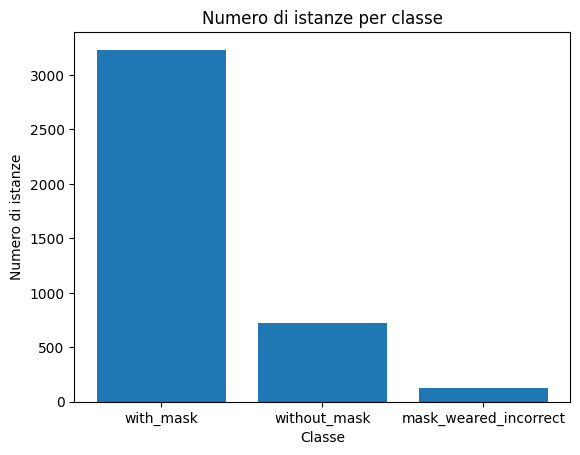

In [ ]:
# Calcolo del numero di istanze per ogni classe
with_mask, without_mask, incorrect_mask = count_classes_instances("/content/annotations")

print("Istanze della classe [with_mask]             : " + str(with_mask))
print("Istanze della classe [without_mask]          : " + str(without_mask))
print("Istanze della classe [mask_weared_incorrect] : " + str(incorrect_mask))

# Visualizzazione istogramma
draw_hist(with_mask, without_mask, incorrect_mask)

Come si può notare dal precedente istogramma, la terza classe presentava un numero estremamente ridotto di istanze rispetto alle altre classi, il che avrebbe potuto influire negativamente sull'addestramento del modello e sulla capacità di generalizzazione dei risultati. Di conseguenza, è stato deciso di eliminare la terza classe per garantire un bilanciamento adeguato tra le 2 classi rimanenti.


Istanze della classe [with_mask]             : 3232
Istanze della classe [without_mask]          : 717
Istanze della classe [mask_weared_incorrect] : 0


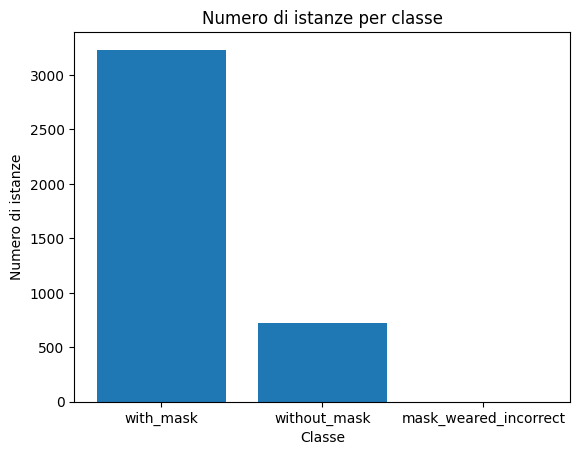

In [ ]:
# Rimozione della classe "mask_weared_incorrect"
delete_class("mask_weared_incorrect", "/content/annotations", "/content/images")

# Calcolo del numero di istanze per ogni classe
with_mask, without_mask, incorrect_mask = count_classes_instances("/content/annotations")

print("Istanze della classe [with_mask]             : " + str(with_mask))
print("Istanze della classe [without_mask]          : " + str(without_mask))
print("Istanze della classe [mask_weared_incorrect] : " + str(incorrect_mask))

# Visualizzazione istogramma
draw_hist(with_mask, without_mask, incorrect_mask)

## Divisione del dataset

Nella cella sottostante sono create le cartelle relative ai sottoinsiemi del dataset (training, validation e test) grazie al comando *makedirs()* del modulo *os* (operating system).



In [ ]:
os.makedirs('train_images', exist_ok=True)
os.makedirs('train_annotations', exist_ok=True)
os.makedirs('val_images', exist_ok=True)
os.makedirs('val_annotations', exist_ok=True)
os.makedirs('test_images', exist_ok=True)
os.makedirs('test_annotations', exist_ok=True)

Il dataset viene inizialmente diviso in 2 sottoinsiemi, quello relativo all'addestramento (training e validation set) e quello di test (test set).

Successivamente le immagini e le annotazioni di test sono spostate nelle apposite directory (*test_images* e *test_annotations*).

In [ ]:
# Calcolo del numero totale di immagini
len_dataset = len(glob.glob('/content/images/*.png'))

# Divisione in training/validation e test set
train_val_indices, test_indices = train_test_split(
    np.arange(len(glob.glob('/content/images/*.png'))), test_size=0.2, random_state=42, shuffle=True)

# Spostamento immagini e annotazioni di test nelle relative cartelle
move_images_and_annotations('test_images', 'test_annotations', itemgetter(*test_indices)(glob.glob('/content/images/*.png')))

Ora la parte di dataset relativa all'addestramento viene divisa in training e validation set, dopodichè, le immagini e le annotazioni vengono spostate nelle relative cartelle.

Abbiamo trovato molto utile l'utilizzo della funzione *itemgetter* del modulo *operator* per riuscire ad estrarre solamente le immagini relative agli indici calcolati dalla funzione *train_test_split* del modulo *model_selection* di Scikit-learn.

In [ ]:
# Elenco delle immagini rimaste nella cartella 'images'.
images_paths = glob.glob('/content/images/*.png')

# Divisione in training e validation set
train_indices, val_indices = train_test_split(
    np.arange(len(train_val_indices)), test_size=0.3, random_state=42, shuffle=True)

# Spostamento delle immagini e delle annotazioni nelle relative cartelle
move_images_and_annotations('train_images', 'train_annotations', itemgetter(*train_indices)(images_paths))
move_images_and_annotations('val_images', 'val_annotations', itemgetter(*val_indices)(images_paths))

Il seguente blocco di stampa a video il numero totale di immagini nei tre sottoinsiemi del dataset e il numero di istanze di ogni classe per ogni sottoinsieme.


In [ ]:
# Calcolo del numero di istanze per ogni classe per ogni sottoinsieme del dataset
with_mask_train, without_mask_train, _ = count_classes_instances("/content/train_annotations")
with_mask_val, without_mask_val, _ = count_classes_instances("/content/val_annotations")
with_mask_test, without_mask_test, _ = count_classes_instances("/content/test_annotations")


print('Cardinalità immagini dataset        : ' + str(len_dataset))
print('Istanze della classe [with_mask]    : ' + str(with_mask))
print('Istanze della classe [without_mask] : ' + str(without_mask))
print()
print('Cardinalità immagini training set   : ' + str(len(train_indices)))
print('Istanze della classe [with_mask]    : ' + str(with_mask_train))
print('Istanze della classe [without_mask] : ' + str(without_mask_train))
print()
print('Cardinalità immagini validation set : ' + str(len(val_indices)))
print('Istanze della classe [with_mask]    : ' + str(with_mask_val))
print('Istanze della classe [without_mask] : ' + str(without_mask_val))
print()
print('Cardinalità immagini test set       : ' + str(len(test_indices)))
print('Istanze della classe [with_mask]    : ' + str(with_mask_test))
print('Istanze della classe [without_mask] : ' + str(without_mask_test))

Cardinalità immagini dataset        : 832
Istanze della classe [with_mask]    : 3232
Istanze della classe [without_mask] : 717

Cardinalità immagini training set   : 465
Istanze della classe [with_mask]    : 1673
Istanze della classe [without_mask] : 362

Cardinalità immagini validation set : 200
Istanze della classe [with_mask]    : 866
Istanze della classe [without_mask] : 215

Cardinalità immagini test set       : 167
Istanze della classe [with_mask]    : 693
Istanze della classe [without_mask] : 140


## Struttura e logica del dataset

In questa sottosezione viene implementata una struttura e una logica per la gestione del dataset. In particolare, viene creata una classe *MaskDataset*, che estende la classe astratta *Dataset* di PyTorch, aggiungendo la logica necessaria per gestire immagini e annotazioni del nostro set di dati.

Successivamente, vengono istanziati i *DataLoaders* per ogni sottoinsieme del dataset.

### Funzioni di utilità

Per migliorare la leggibilità del codice sono state definite alcune funzioni di utilità, quali:
- **generate_box(obj)** - Restituisce una lista contenente le coordinate delle bounding box leggendole dall'*object* passato come parametro in input;
- **generate_label(obj)** - Restituisce l'intero corrispondente alla classe dell'*object* ricevuto in input;
- **generate_target(file)** - Restituisce un dizionario contenente le coordinate e le etichette relative al file specificato nel percorso di input;
- **collate_fn(batch)** - Funzione utilizzata per combinare i campioni di un *batch* in tuple. Essa viene passata in input al *Data Loader*;


In [ ]:
def generate_box(obj):
    # Estrazione delle coordinate
    xmin = float(obj.find('bndbox/xmin').text)
    ymin = float(obj.find('bndbox/ymin').text)
    xmax = float(obj.find('bndbox/xmax').text)
    ymax = float(obj.find('bndbox/ymax').text)

    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "without_mask":
        return 2

    return 0

def generate_target(path):
  tree = ET.parse(path)
  root = tree.getroot()

  boxes = []
  labels = []

  # Salvataggio delle bounding box e delle relative label
  for obj in root.findall("object"):
      boxes.append(generate_box(obj))
      labels.append(generate_label(obj))

  # Conversione a tensori
  boxes = torch.as_tensor(boxes, dtype=torch.float32)
  labels = torch.as_tensor(labels, dtype=torch.int64)

  target = {}
  target["boxes"] = boxes
  target["labels"] = labels

  return target

def collate_fn(batch):
    return tuple(zip(*batch))

### Creazione del Dataset

La classe **MaskDataset** rappresenta un dataset personalizzato. E' stata implementata estendendo la classe *torch.utils.data.Dataset* di PyTorch, offrendo un'interfaccia per accedere alle immagini e alle relative etichette.

Nello specifico, sono presenti 3 metodi:
- **\__init__(..)** - Metodo di inizializzazione che prende in input il percorso del dataset (*path*) ed eventuali trasformazioni sui dati (*transform*);
- **\__len__(..)** - Restituisce la lunghezza del dataset;
- **\__getitem__(..)** - Restituisce l'elemento corrispondente all'indice *idx* passato in input;

In [ ]:
class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("/content/test_annotations/", file_label)
        elif 'val' in self.path:
            label_path = os.path.join("/content/val_annotations/", file_label)
        else:
            label_path = os.path.join("/content/train_annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)

        if self.transform:
            img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)

        to_tensor = torchvision.transforms.ToTensor()
        img = to_tensor(img)

        return img, target

Dopo aver definito le funzioni di utilità e la classe per la gestione del dataset, è possibile istanziare i 3 sottoinsiemi del set di dati.



In [ ]:
train_dataset = MaskDataset('/content/train_images/')
val_dataset = MaskDataset('/content/val_images/')
test_dataset = MaskDataset('/content/test_images/')

Nella cella sottostante vengono creati i 3 **Data Loaders** che poi verranno utilizzati successivamente per iterare sui batch di dati durante la fase di addestramento.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

# Importazione del modello

Inizialmente è stato scaricato un modello di RetinaNet con pesi preaddestrati. La rete, basandosi su essi, è stata poi addestrata sul nostro dataset.
Durante questo processo, i pesi del modello sono stati adattati al nostro set di dati.
Al termine dell'addestramento, i nuovi pesi sono stati salvati.

Nella cella successiva viene istanziato il modello di **Retina Net ResNet 50 FPN** di PyTorch impostando il numero delle classi pari a 3 (background, with_mask e without_mask) e il parametro *pretrained* a false.



In [ ]:
# retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained=False)
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained_backbone=True, progress=True)

## Caricamento di un modello preaddestrato

E' di seguito riportato il codice per caricare i pesi personalizzati nel modello.

Inizialmente, vengono filtrati i file che matchano un determinato pattern, poi vengono ordinati in ordine decrescente in base al loro nome.

Successivamente, vengono caricati i pesi relativi al primo file nella lista, che contiene i pesi dell'addestramento più recente.

In [ ]:
# Pull del file coi pesi più recenti
directory = "/content/drive/MyDrive/visione-artificiale/"

# Ottieni l'elenco dei file nella directory
files = os.listdir(directory)

# Filtra solo i file che iniziano per "retina" e hanno l'estensione ".pt"
filtered_files = [f for f in files if re.match(r"retina.*\.pt", f)]

# Ordina i file in base al numero e, in caso di numeri uguali, al secondo numero
sorted_files = sorted(filtered_files, key=lambda f: tuple(map(int, re.findall(r'\d+', f))), reverse=True)

# Se ci sono file nella lista ordinata, seleziona il primo file
if sorted_files:
    first_file = sorted_files[0]
    print(directory + first_file)

    # Carica l'ultima versione del modello salvato
    retina = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=False, num_classes=3)
    retina.load_state_dict(torch.load(directory + first_file))
else:
    print("Nessun file trovato.")
    retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained_backbone=True, progress=True)

Nessun file trovato.


# Addestramento del modello

La cella sottostante contiene il codice per allenare il modello di *Retina Net* per un numero di epoche pari a *num_epochs* sfruttando l'ottimizzatore *SGD* di PyTorch.

In [ ]:
# Determina il dispotivo di esecuzione (se disponibile una GPU, altrimenti una CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Sposta il modello sul dispositivo di esecuzione
retina.to(device)

# Numero di epoche
num_epochs = 200

# Seleziona i parametri che richiedono il calcolo del gradiente durante l'addestramento
params = [p for p in retina.parameters() if p.requires_grad]

# Inizializzazione dell'ottimizzatore di tipo Stochastic Gradient Descent (SGD)
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Liste per salvare i valori della loss sul training e sul validation set
train_loss_list, val_loss_list = [], []  # lista per salvare i valori di train_loss ad ogni iterazione

# Impostazione del modello in modalità di addestramento
retina.train()

# Addestramento
for epoch in range(num_epochs):

    # Registrazione tempo di inizio dell'epoca corrente
    start = time.time()

    train_loss = 0

    for images, targets in train_loader:

        # Le immagini e le etichette sono spostate sul dispositivo di esecuzione
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Predizione del modello
        loss_dict = retina(images, targets)

        # Somma dei valori di loss per ogni predizione
        losses = sum(loss for loss in loss_dict.values())

        # Azzeramento dell'ottimizzatore
        optimizer.zero_grad()

        # Backpropagation
        losses.backward()

        # Aggiornamento dei pesi
        optimizer.step()

        # Aggiunta delle loss alla lista
        train_loss += losses.item() # Per ottenere il valore scalare

    # Salvataggio dei valori di loss sul training set per l'epoca corrente
    train_loss_list.append(train_loss)


    # Valutazione del modello utilizzando il validation set
    with torch.no_grad():
        val_loss = 0
        for val_images, val_targets in val_loader:

            # Le immagini e le etichette sono spostate sul dispositivo di esecuzione
            val_images = list(image.to(device) for image in val_images)
            val_targets = [{k: v.to(device) for k, v in t.items()} for t in val_targets]

            # Predizione del modello
            val_loss_dict = retina(val_images, val_targets)

            # Somma dei valori di loss per ogni predizione
            val_losses = sum(val_loss for val_loss in val_loss_dict.values())

            # Aggiunta delle loss alla lista
            val_loss += val_losses.item()

    # Salvataggio dei valori di loss sul validation set per l'epoca corrente
    val_loss_list.append(val_loss)

    # Calcolo del tempo totale dell'epoca corrente
    elapsed_time = time.time() - start

    print('Epoch [' + str(epoch) + '] train_loss --> ' + str(round(train_loss, 3)) + '| val_loss --> ' + str(round(val_loss, 3)) + ' | time --> ' + str(round(elapsed_time, 3)))


Epoch [0] train_loss --> 190.458| val_loss --> 75.585 | time --> 208.312
Epoch [1] train_loss --> 181.746| val_loss --> 75.713 | time --> 206.229
Epoch [2] train_loss --> 164.553| val_loss --> 62.089 | time --> 205.846
Epoch [3] train_loss --> 111.671| val_loss --> 38.85 | time --> 205.87
Epoch [4] train_loss --> 96.754| val_loss --> 35.578 | time --> 205.727
Epoch [5] train_loss --> 67.015| val_loss --> 26.85 | time --> 205.921
Epoch [6] train_loss --> 57.04| val_loss --> 25.938 | time --> 206.155
Epoch [7] train_loss --> 52.624| val_loss --> 25.775 | time --> 206.182
Epoch [8] train_loss --> 49.382| val_loss --> 25.535 | time --> 206.59
Epoch [9] train_loss --> 45.118| val_loss --> 22.541 | time --> 206.543
Epoch [10] train_loss --> 39.804| val_loss --> 22.579 | time --> 206.019
Epoch [11] train_loss --> 37.418| val_loss --> 23.689 | time --> 206.652
Epoch [12] train_loss --> 35.681| val_loss --> 23.138 | time --> 206.26
Epoch [13] train_loss --> 36.382| val_loss --> 21.623 | time --

## Salvataggio dei pesi

Dopo aver eseguito l'addestramento i pesi del modello vengono salvati su *Google Drive* sottoforma di *file.pt* indicando il numero di epoche nel nome.

In [ ]:
torch.save(retina.state_dict(), '/content/drive/MyDrive/retina-200-epochs.pt')

In [ ]:
# Salvataggio dei pesi appena calcolati
# Estrazione del numero dal nome del file esistente
existing_num = int(first_file.split('-')[1])

# Calcola la nuova somma dei num_epochs
new_num_epochs = num_epochs + existing_num

i = 1
while True:
    if i == 1:
        filename = f"retina-{new_num_epochs}-epochs.pt"
    else:
        filename = f"retina-{new_num_epochs}-epochs-{i}.pt"
    filepath = os.path.join('/content/drive/MyDrive/visione-artificiale', filename)

    if not os.path.exists(filepath):
        torch.save(retina.state_dict(), filepath)
        break
    i += 1

# Valutazione delle prestazioni

In questa sezione del notebook, viene affrontata la valutazione delle performance del modello, che rappresenta un elemento fondamentale per misurare l'accuratezza e l'efficacia di una rete.

## Funzioni di utilità

Nella cella sottostante sono definite alcune funzioni di utilità utilizzate nella fase di valutazione delle prestazioni, nello specifico:
- **make_prediction(model, img, thresh)** - Restituisce le predizioni del modello *model* sull'immagine *img* dopo aver applicato la soglia *thresh* per selezionare le più rilevanti;
- **bbox_iou(box1, box2)** - Calcola l'*Intersection over Union* (IoU) tra le due bounding box *box1* e *box2*;
- **get_batch_statistics(outputs, targets, iou_threshold)** - Calcola le metrice di valutazione di interesse (veri/falsi positivi e veri/falsi negativi riferiti a classificazione e rilevazione, oltre ai valori di IoU);
- **normalize_confusion_matrix(conf_matrix)** - Normalizza la matrice di confusione *conf_matrix* dividendo ciascun elemento per la somma della riga corrispondente;
- **show_confusion_matrix(conf_matrix, class_names)** - Visualizza la matrice di confusione normalizzata, rappresentandola sotto forma di heatmap;
- **plot_image_from_output(img, ann)** - Restituisce l'immagine con le dimensioni permutate, e una lista di *patches.Rectangle* corrispondenti alle annotazioni *ann* passate in input;
- **ap_per_class(tp, conf, pred_cls, target_cls)** - Calcola precision, recall, average precision e F1 score per ciascuna classe. [Crediti](https://github.com/rafaelpadilla/Object-Detection-Metrics);
- **compute_ap(recall, precision)** - Calcola l'average precision date in input le curve di precision e recall. [Crediti](https://github.com/rbgirshick/py-faster-rcnn);





In [ ]:
def make_prediction(model, img, thresh):
    # Imposta il modello in fase di inferenza
    model.eval()

    # Predizione
    preds = model(img)

    for id in range(len(preds)):
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            # Seleziona gli indici delle predizioni maggiori della soglia passata in input
            if score > thresh :
                idx_list.append(idx)

        # Salva coordinate, etichetta e score delle predizioni selezionate
        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

def bbox_iou(box1, box2):

    # Calcolo delle coordinate delle due bounding box
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # Calcolo delle coordinate del rettangolo di intersezione tra le due bounding box
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)

    # Calcolo dell'area di intersezione
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)

    # Calcolo dell'area di unione
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    # Calcolo dell'IoU
    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def get_batch_statistics(outputs, targets, iou_threshold):
    batch_metrics = []
    tp_batch_count, fp_batch_count, fn_batch_count = 0, 0, 0
    conf_tp, conf_tn, conf_fp, conf_fn = 0, 0, 0, 0
    class_dict = {1: 'with_mask', 2: 'without_mask'}
    iou_list = []

    # Itera tutte le immagini predette
    for sample_i in range(len(outputs)):

        # Se non sono state predette bounding box per l'immagine corrente, si passa alla prossima
        if outputs[sample_i] is None:
            continue

        # Estrae le predizioni sull'immagine corrente
        output = outputs[sample_i]

        # Tensore per tenere traccia dei veri positivi
        true_positives = torch.zeros(output['boxes'].shape[0])

        # Estrae le annotazioni di ground truth per l'immagine corrente
        annotations = targets[sample_i]
        target_labels = annotations['labels'] if len(annotations) else []

        # Se esistono annotazioni reali per l'immagine corrente
        if len(annotations):
            detected_boxes = []
            target_boxes = annotations['boxes']

            # Itera attraverso le predizioni per l'immagine corrente
            for pred_i, (pred_box, pred_label) in enumerate(zip(output['boxes'], output['labels'])):

                # Se il numero di bounding box corrette trovate è uguale al numero di
                # bounding box nel ground truth, interrompe il ciclo perchè tutte le
                # etichette sono state trovate
                if len(detected_boxes) == len(target_labels):
                    break

                # Ignora la predizione se la label predetta non è una delle label del ground truth
                if pred_label not in target_labels:
                    continue

                # Calcolo dell'IoU tra la miglior bounding box predetta e quella originale
                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)

                # Se l'IoU è maggiore della soglia ricevuta in input e la bounding box corrispondente
                # non è stata già individuata correttamente, segnala la predizione come true positive.
                if iou > iou_threshold:
                    true_positives[pred_i] = 1
                    tp_batch_count += 1

                    # Aggiornamento dei true/false positives e dei true/false negatives per la classificazione
                    if class_dict[output['labels'][pred_i].item()] == "with_mask":
                      if class_dict[target_labels[box_index].item()] == "with_mask":
                        conf_tp = conf_tp + 1
                        iou_list.append(iou)
                      elif class_dict[target_labels[box_index].item()] == "without_mask":
                        conf_fp = conf_fp + 1
                    elif class_dict[output['labels'][pred_i].item()] == "without_mask":
                      if class_dict[target_labels[box_index].item()] == "with_mask":
                        conf_fn = conf_fn + 1
                      elif class_dict[target_labels[box_index].item()] == "without_mask":
                        conf_tn = conf_tn + 1
                        iou_list.append(iou)

                    detected_boxes += [pred_i]

        # FN = Numero totale di bounding box nel ground truth - Numero di true positives (TP)
        fn_batch_count += len(target_labels) - len(detected_boxes)

        # FP = Numero totale di bounding box predette - Numero di true positives (TP)
        fp_batch_count += len(output['labels']) - len(detected_boxes)

        batch_metrics.append([true_positives, output['scores'], output['labels']])

    return tp_batch_count, fp_batch_count, fn_batch_count, conf_tp, conf_tn, conf_fp, conf_fn, batch_metrics, iou_list

def normalize_confusion_matrix(conf_matrix):
    # Somma degli elementi per ogni riga della matrice
    row_sums = conf_matrix.sum(axis=1)

    # Normalizzazione
    normalized_conf_matrix = conf_matrix / row_sums[:, np.newaxis]

    return normalized_conf_matrix

def show_confusion_matrix(conf_matrix, class_names, figsize=(10, 10)):
    # Normalizzazione
    normalized_conf_matrix = normalize_confusion_matrix(conf_matrix)

    # Creazione della griglia
    fig, ax = plt.subplots(figsize=figsize)
    img = ax.matshow(normalized_conf_matrix)
    tick_marks = np.arange(len(class_names))
    _ = plt.xticks(tick_marks, class_names, rotation=45)
    _ = plt.yticks(tick_marks, class_names)
    _ = plt.ylabel('Real')
    _ = plt.xlabel('Predicted')

    # Aggiunta dei valori percentuali
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, '{0:.1%}'.format(normalized_conf_matrix[i, j]),
                           ha='center', va='center', color='w')

def plot_image_from_output(img, annotation):
    # Sposta l'immagine sulla CPU e permuta i canali nel formato richiesto
    img = img.cpu().permute(1,2,0)

    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        # RED = BACKGROUND | GREEN = WITH_MASK | ORANGE = WITHOUT_MASK
        if annotation['labels'][idx] == 0:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        elif annotation['labels'][idx] == 1:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        # Ogni bounding box viene aggiunta alla lista
        rects.append(rect)

    return img, rects

def ap_per_class(tp, conf, pred_cls, target_cls):
    # Sort by objectness
    i = torch.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = torch.unique(target_cls)

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in unique_classes:
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = torch.cumsum(1 - tp[i],-1)
            tpc = torch.cumsum(tp[i],-1)

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = torch.tensor(np.array(p)), torch.tensor(np.array(r)), torch.tensor(np.array(ap))
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes

def compute_ap(recall, precision):
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

## Training e validation loss

Eseguendo la cella sottostante viene mostrato il grafico delle loss relative a training e validation set. Il grafico rappresenta l'andamento delle loss nel corso delle epoche, fornendo una visualizzazione delle performance del modello durante il processo di addestramento.

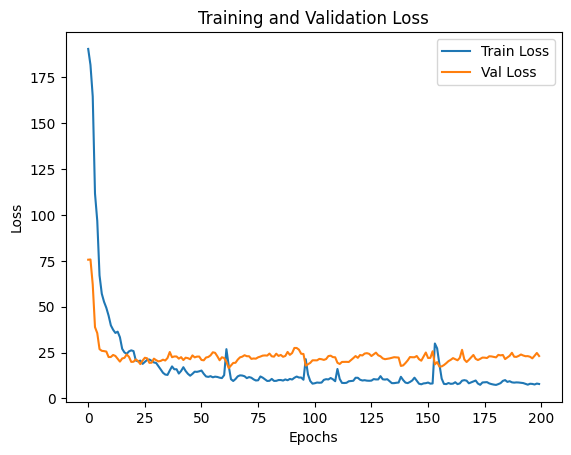

In [ ]:
# Grafico delle loss su train e validation set
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

## Predizioni del modello

In questa sezione vengono mostrate le predizioni su tutte le immagini di test utilizzando il modello *RetinaNet*.

Nello specifico, le predizioni vengono effettuate utilizzando la funzione *make_prediction* (applicando una soglia di 0.5) per poi essere salvate nella lista *preds_adj_all*. Le annotazioni originali vengono salvate nella lista *annot_all*.


In [ ]:
labels, preds_adj_all, annot_all = [], [], []

for im, annot in tqdm(test_loader, position = 0, leave = True):
    # Sposta le immagini sul dispositivo di esecuzione
    im = list(img.to(device) for img in im)

    # Aggiunta delle annotazioni alla lista labels
    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        # Predizione
        preds_adj = make_prediction(retina, im, 0.5)

        # Sposta le predizioni sulla CPU per evitare accumuli di memoria nella GPU
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]

        # Salvataggio di annotazioni predette e originali
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 84/84 [00:23<00:00,  3.61it/s]


Eseguendo la cella sottostante verrà mostrato un confronto visivo tra i dati di ground truth e le relative predizioni.

Nella colonna *True* vengono visualizzate le immagini di test con le annotazioni originali, mentre nella colonna *Pred* vengono mostrate le immagini di test con le annotazioni predette dal modello.

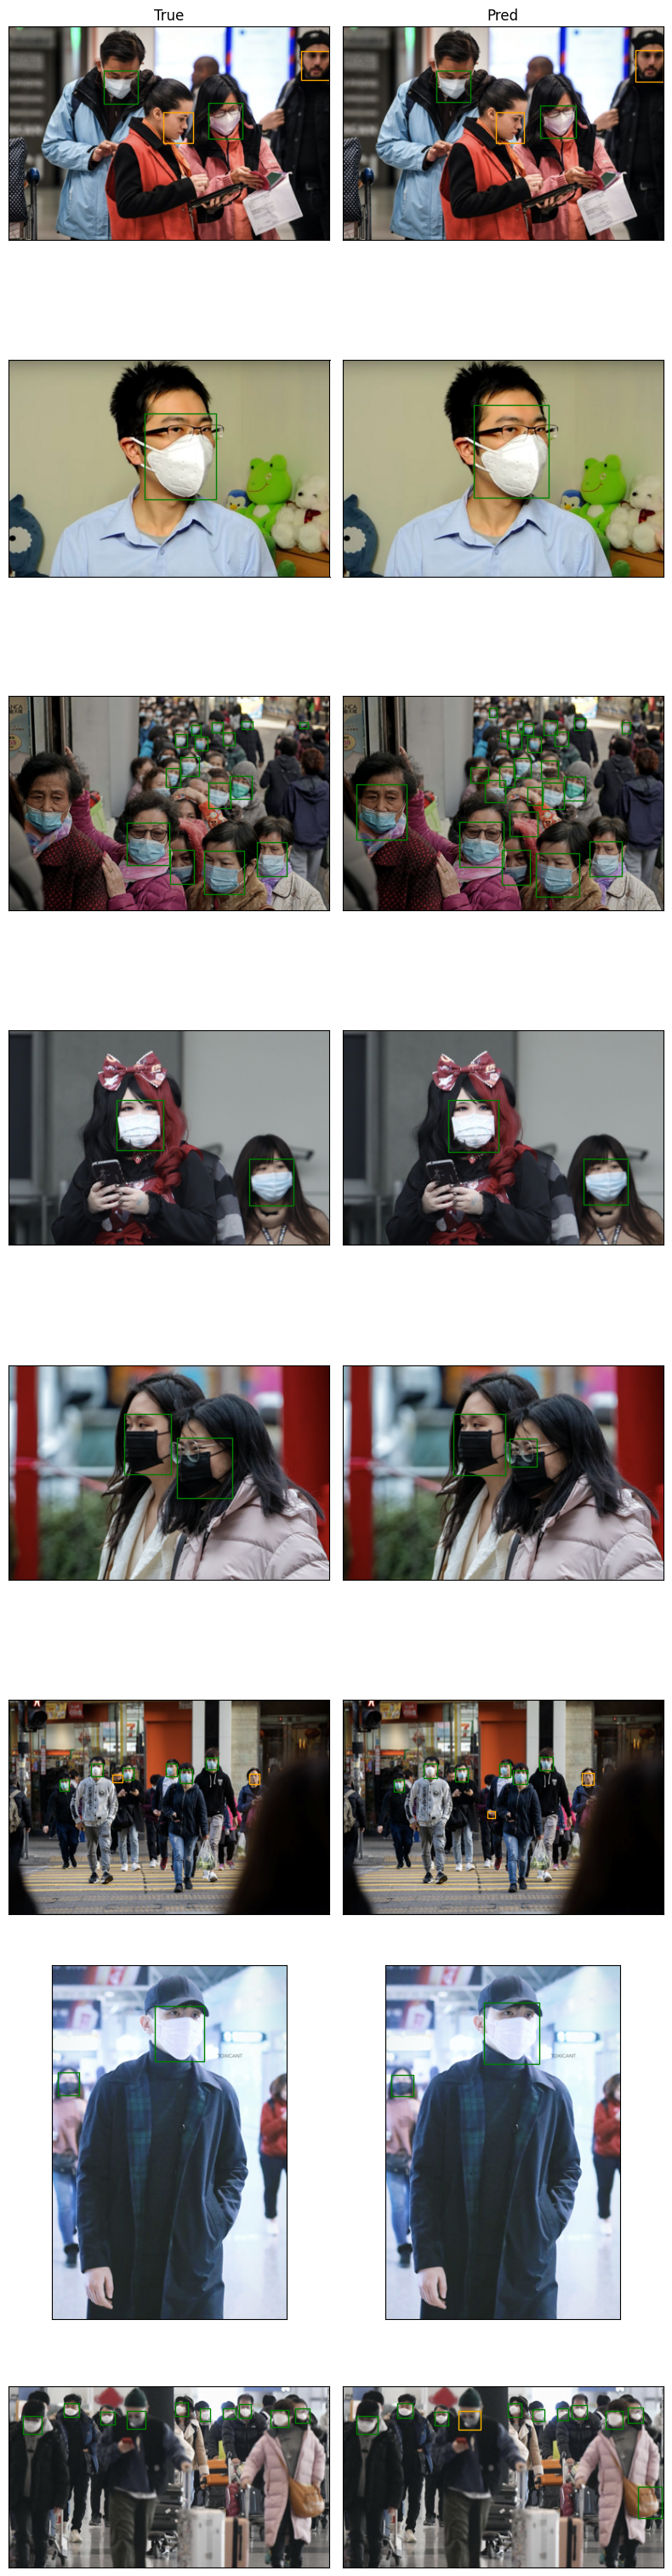

In [ ]:
nrows, ncols = 8, 2

# Creazione della griglia
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        # Creazione delle bounding box e permutazione delle dimensioni dell'immagine
        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])

        # Visualizzazione dell'immagine di test
        axes[(pos)//2, 1-((pos)%2)].imshow(img)

        # Aggiunta delle bounding box originali all'immagine
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)

        # Creazione delle bounding box e permutazione delle dimensioni dell'immagine
        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])

        # Visualizzazione dell'immagine di test
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)

        # Aggiunta delle bounding box predette all'immagine
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# Rimozione assi
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

# Aggiunta dei nomi alle colonne
for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

# Visualizzazione
plt.tight_layout()
plt.show()

## Calcolo delle metriche di valutazione per le predizioni del modello

Il seguente codice calcola una serie di metriche di valutazione per analizzare le prestazioni del modello nella rilevazione e nella classificazione delle mascherine.

Nello specifico, vengono calcolati i seguenti indici:
- **Rilevazione:** i seguenti indici sono calcolati per valutare l'accuratezza del modello nel rilevare le mascherine;
  - **tp_total_count** - I veri positivi indicano se il modello ha individuato correttamente una bounding box in corrispondenza delle annotazioni presenti nel ground truth. In altre parole, i true positive rappresentano i casi in cui il modello ha correttamente rilevato una bounding box dove effettivamente era presente un'annotazione;

  - **fp_total_count** - I falsi positivi indicano i casi in cui il modello ha erroneamente individuato una bounding box anche quando non era presente un'annotazione nel ground truth;

  - **fn_total_count** - I falsi negativi indicano i casi in cui il modello non è riuscito a individuare correttamente una bounding box anche quando era presente un'annotazione nel ground truth;

  - **iou_total_list** - Lista delle IoU;

  - **avg_iou_list** - Media delle IoU;

- **Classificazione:** i seguenti indici sono calcolati per valutare l'accuratezza del modello nel classificare le mascherine rilevate correttamente (*tp_total_count*);

  - **conf_total_tp** - I veri positivi rappresentano i casi in cui il modello ha predetto correttamente la classe *with_mask*;

  - **conf_total_tn** - I veri negativi rappresentano i casi in cui il modello ha predetto correttamente la classe *without_mask*;

  - **conf_total_fp** - I falsi positivi indicano i casi in cui il modello ha erroneamente predetto la classe *with_mask* anche se la mascherina non era presente;

  - **conf_total_fn** - I falsi negativi indicano i casi in cui il modello ha erroneamente predetto la classe *without_mask* anche se la mascherina era presente;


In [ ]:
tp_total_count, fp_total_count, fn_total_count = 0, 0, 0
conf_total_tp, conf_total_tn, conf_total_fp, conf_total_fn = 0, 0, 0, 0
sample_metrics = []
iou_total_list = []

for batch_i in range(len(preds_adj_all)):
    tp_batch_count, fp_batch_count, fn_batch_count, conf_tp, conf_tn, conf_fp, conf_fn, support_metrics, iou_batch_list = get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)
    sample_metrics += support_metrics
    tp_total_count += tp_batch_count
    fp_total_count += fp_batch_count
    fn_total_count += fn_batch_count
    conf_total_tp += conf_tp
    conf_total_tn += conf_tn
    conf_total_fp += conf_fp
    conf_total_fn += conf_fn
    iou_total_list = np.concatenate((iou_total_list, iou_batch_list))

print(f'tp_total_count : {tp_total_count}')
print(f'fp_total_count : {fp_total_count}')
print(f'fn_total_count : {fn_total_count}')
print()
print(f'conf_total_tp  : {conf_total_tp}')
print(f'conf_total_tn  : {conf_total_tn}')
print(f'conf_total_fp  : {conf_total_fp}')
print(f'conf_total_fn  : {conf_total_fn}')
print()
print(f'len_iou_list   : {len(iou_total_list)}')
print(f'avg_iou_list   : {round(iou_total_list.mean(), 4)}')


tp_total_count : 741
fp_total_count : 110
fn_total_count : 92

conf_total_tp  : 620
conf_total_tn  : 114
conf_total_fp  : 6
conf_total_fn  : 1

len_iou_list   : 734
avg_iou_list   : 0.8103


Nella cella sottostante viene richiamata la funzione *ap_per_class* per calcolare:
- **Precision**
- **Recall**
- **Average Precision (AP)**
- **F1**
- **AP per ogni classe**


In [ ]:
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
split_precision, split_recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP.float())

## Precision e Recall

La **precision** e la **recall** sono due misure fondamentali utilizzate per valutare le prestazioni di un modello di riconoscimento delle mascherine. Entrambe le misure sono importanti per valutare l'accuratezza e l'efficacia del modello nel riconoscere correttamente la presenza o l'assenza di mascherine nelle immagini analizzate.

La **precision** misura la proporzione di previsioni corrette rispetto a tutte le previsioni positive effettuate dal modello. Indica quanto il modello è preciso nel riconoscere correttamente le mascherine e le loro assenze. Un valore elevato di precisione significa che il modello ha una bassa percentuale di falsi positivi, ovvero ha fatto poche previsioni errate sulle mascherine.

D'altra parte, la **recall** misura la proporzione di oggetti positivi correttamente individuati dal modello rispetto al numero totale di oggetti positivi presenti nel dataset di riferimento. Rappresenta la capacità del modello di individuare tutti gli oggetti positivi in modo completo e accurato. Una recall elevata indica che il modello riesce a individuare la maggior parte delle mascherine correttamente, riducendo al minimo i cosiddetti falsi negativi, ovvero le mascherine non riconosciute.

In questo contesto, la precisione non è calcolata separatamente per ogni classe, ma rappresenta una valutazione complessiva delle prestazioni del modello nell'identificare correttamente entrambe le classi.

In [ ]:
mean_precision = tp_total_count / (tp_total_count + fp_total_count)
mean_recall = tp_total_count / (tp_total_count + fn_total_count)

print(f'Mean Precision : {mean_precision}')
print(f'Mean Recall    : {mean_recall}')

Mean Precision : 0.8707403055229143
Mean Recall    : 0.8895558223289316


Eseguendo la seguente cella verrà mostrato il valore di precision e recall per le due classi del problema (*with_mask* e *without_mask*).


In [ ]:
print(f'Precision : {split_precision}')
print(f'Recall    : {split_recall}')

Precision : tensor([0.8768, 0.8394])
Recall    : tensor([0.9033, 0.8214])


## F1 Score

L'**F1-score** è una misura complessiva delle prestazioni di un modello che tiene conto sia della precisione che della recall. È definita come la media armonica di precisione e recall e fornisce una stima bilanciata delle prestazioni del modello.

La media armonica è utilizzata come formula di aggregazione perché penalizza i valori bassi in modo più significativo rispetto alla media aritmetica. Questo significa che se uno dei due valori (precisione o recall) è molto basso, l'F1-score sarà influenzato negativamente e risulterà essere un valore basso.

In [ ]:
print(f'f1 : {f1}')

f1 : tensor([0.8898, 0.8303])


## Average Precision e medium Average Precision

L'**Average Precision** (AP) rappresenta la precisione media del modello per ciascuna classe. Viene calcolato calcolando l'area sotto la curva di precisione-recall per la classe specifica. L'AP valuta la capacità del modello di effettuare previsioni precise (precisione) e di individuare correttamente gli oggetti positivi (recall) per quella specifica classe. Un valore di AP più alto indica una migliore performance del modello per quella classe.

Il **mean Average Precision** (mAP) rappresenta la media delle Average Precision (AP) calcolate per tutte le classi del problema. È una misura complessiva delle prestazioni del modello che tiene conto delle varie classi affrontate. Il mAP fornisce una stima generale dell'accuratezza e della capacità del modello di riconoscere correttamente gli oggetti di diverse classi.



In [ ]:
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.8392117023468018
AP : tensor([0.8924, 0.7860], dtype=torch.float64)


## Matrice di confusione

E' di seguito riportato il codice per creare la matrice di confusione utilizzando i conteggi totali dei true positives (*conf_total_tp*), false positives (*conf_total_fp*), false negatives (*conf_total_fn*) e true negatives (*conf_total_tn*).


La matrice di confusione viene rappresentata come un array NumPy con dimensioni 2x2. Successivamente, i valori della matrice sono convertiti ad interi.


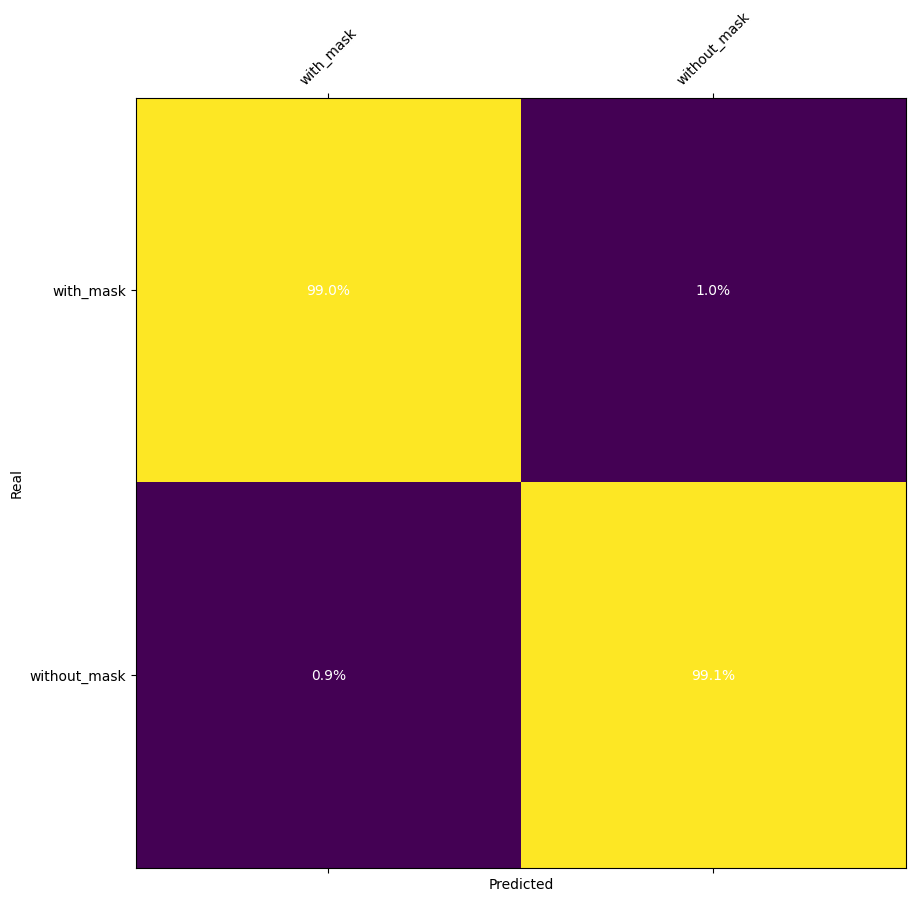

In [ ]:
confusion_matrix = np.array([[conf_total_tp, conf_total_fp], [conf_total_fn, conf_total_tn]])
confusion_matrix = confusion_matrix.astype(int)
class_names = ('with_mask', 'without_mask')
show_confusion_matrix(confusion_matrix, class_names)